In [ ]:
import math
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
import pywt
import sys
import pandas as pd

# Data format:
# Raw data should be in a .txt file with two columns, separated by tabs:
#  - The first column should be a time-series index
#  - The second column should contain the data to be filtered

# Get data:
data = pd.read_csv ("NASDAQ (1).csv")
index = data.iloc[:,0].values
Data = data.iloc[:,1].values
print(index)
print(Data)

['2012/1/3' '2012/1/4' '2012/1/5' ... '2016/12/21' '2016/12/22'
 '2016/12/23']
[2648.72 2648.36 2669.86 ... 5471.43 5447.42 5462.69]


In [ ]:
# read the data and construct the training, validation and test datasets
def construct_datasets(file_name, output_len, wnd_size):
    
    data = np.loadtxt(open(file_name, 'rb'), delimiter=',', skiprows=0)
    
    min_data = np.min(data) #maximum over all possible IMFs and time
    max_data = np.max(data)
    norm_data = (data - min_data) / (max_data - min_data)
    sum_data = np.sum(norm_data, axis = 1) #sum of all IMFs, which is the closing price for that day
    data_len = sum_data.shape[0] #total number of days of data
    sample_num = data_len -  wnd_size - output_len + 1  #total number of samples in the data
 
    # construct the samples from the time series's IMFs
    feats_num = wnd_size * data.shape[1]
    X = np.zeros((sample_num, feats_num + output_len))
    for i in range(sample_num):
        X[i, : -output_len] = norm_data[i : i + wnd_size, :].reshape(feats_num)
        X[i, - output_len :] = sum_data[i + wnd_size : i + wnd_size + output_len]
   
    #np.random.shuffle(X) # shuffle the samples (optional)
    
    # divide the samples into training, validation and test datases as the ratio 7:2:1
    train_num = int(math.floor(0.7 * sample_num))
    validate_num = int(math.floor(0.2 * sample_num))
    test_num = int(math.floor(0.1 * sample_num))


    train_X = X[: train_num, : - output_len]
    validate_X = X[train_num : train_num + validate_num, : - output_len]
    test_X = X[train_num + validate_num :, : - output_len]
    
    train_Y = X[: train_num, - output_len :]
    validate_Y = X[train_num : train_num + validate_num, - output_len :]
    test_Y = X[train_num + validate_num :, - output_len :]
    
    return norm_data, max_data, min_data, train_X, train_Y, validate_X, \
        validate_Y, test_X, test_Y

norm_data, max_data, min_data, train_X, train_Y, validate_X, validate_Y, test_X, test_Y = construct_datasets('NASDAQ_imf.csv', 1, 3)
    

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import  Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.optimizers import Adam

#A simple sequential model, to view the architecture uncomment the model.summary line
model = Sequential()
model.add(LSTM(16,input_shape=(train_X.shape[1],)))
model.add(Dense(128))
model.add(Dropout(0.25))
model.add(Dense(32,activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(8))
model.add(Dropout(0.25))
model.add(Dense(1))

model.compile(optimizer="Adam", loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse"), tf.keras.metrics.MeanSquaredError(name="mse")])

model.summary()

model.fit(train_X, train_Y, epochs = 248, batch_size = 25,validation_data=(validate_X, validate_Y))

model.save('model1')
 

In [ ]:
model = load_model('model1')
stock_predicted = model.predict(test_X)
print(f"MSE is {np.sum(np.square(stock_predicted -test_Y))/(test_Y.shape[0])}")

In [ ]:
test_Y_unn =  test_Y*(max_data - min_data) + (min_data*norm_data.shape[1])
stock_predicted_unn = model.predict(test_X)*(max_data - min_data) + (min_data*norm_data.shape[1])



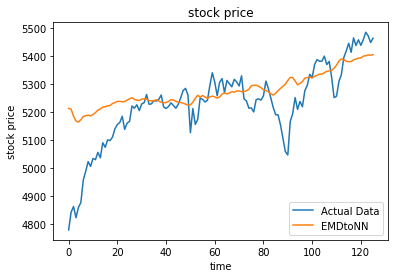

In [ ]:
import matplotlib.pyplot as plt

plt.plot(test_Y_unn)
plt.plot(stock_predicted_unn)
plt.title('stock price')
plt.ylabel('stock price')
plt.xlabel('time')
plt.legend(['Actual Data','EMDtoNN'],loc='lower right')
plt.show()

In [ ]:
# convert array into dataframe
DF = pd.DataFrame(stock_predicted_unn)
  
# save the dataframe as a csv file
DF.to_csv("Predicted_EMDtoNN.csv")

In [ ]:
import pandas as pd